In [359]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
use_neptune = False

In [344]:
import neptune
import tensorflow as tf

import io
import cirq
import numpy as np
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [345]:
use_neptune = True

In [346]:
generator_layers = 3
data_bus_size = 5
rank = 4

In [347]:
real_phase = True
generic_generator = False
zxz = False
all_gates_parametrized = False

In [348]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [349]:
builder = PhaseCircuitBuilder(all_gates_parametrized=False)
real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)

In [350]:
pauli_strings, qubit_to_string_index = quwgans_circuits.get_discriminator(real)

In [351]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [352]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                               │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [353]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───H───@────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                        │
(0, 1): ───────X───Z───Ry(theta0)───H───X───H───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                             │                                     │
(0, 2): ────────────────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                         │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                      │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───

In [354]:
g_values = [-0.8, -0.2]
real_values_provider = get_g_parameters_provider()

In [355]:
opt = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [356]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [357]:
epochs = 5
gen_iteration = 1
snapshot_interval_epochs = 2

In [372]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis-em', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'size':  data_bus_size,
        'rank': rank,
        'real_phase': real_phase,
        'generic_generator': generic_generator,
        'zxz': zxz,
        'all_gates_parametrized': all_gates_parametrized,
        'g_values': g_values,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
    neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/wiktor.jurasz/thesis-em/e/THESEM-9


<Figure size 432x288 with 0 Axes>

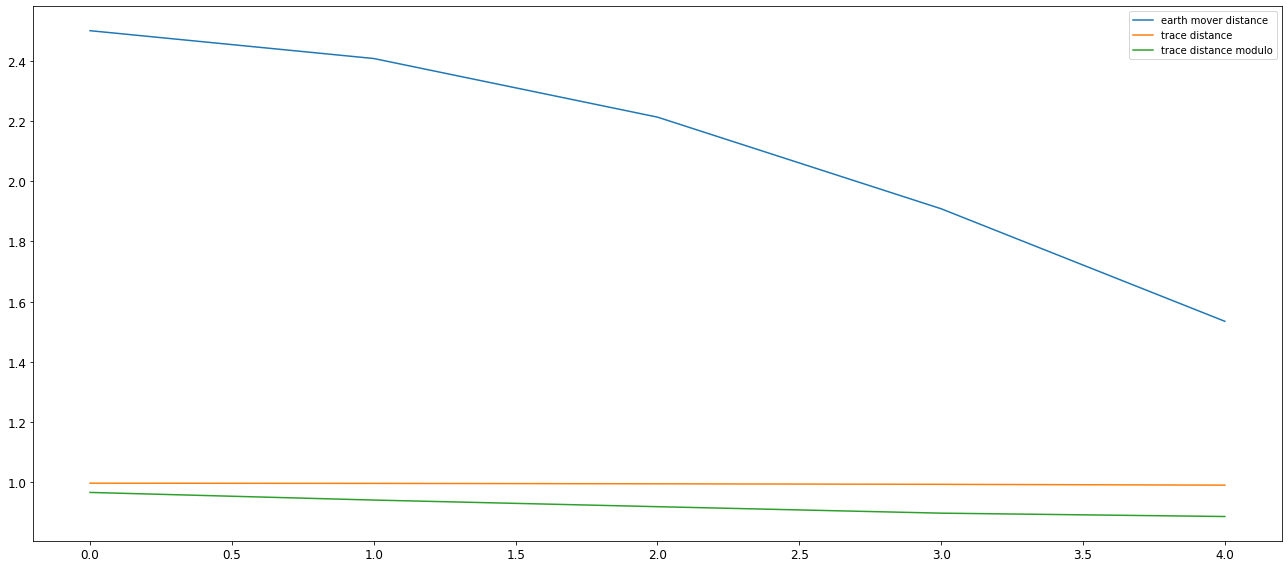

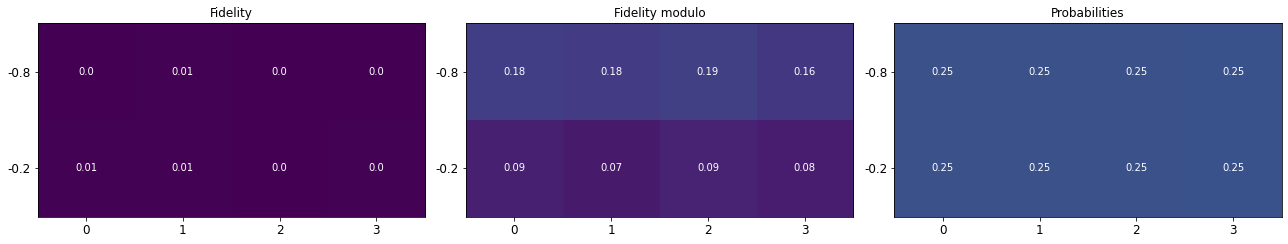

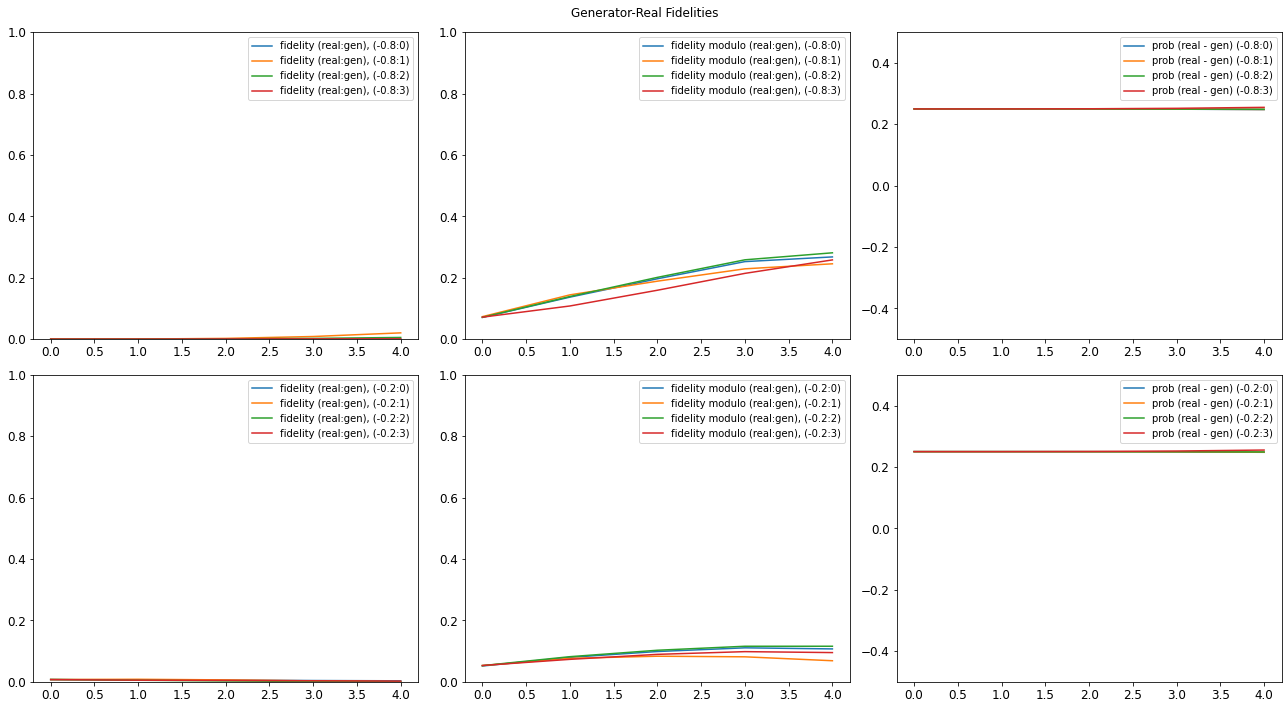

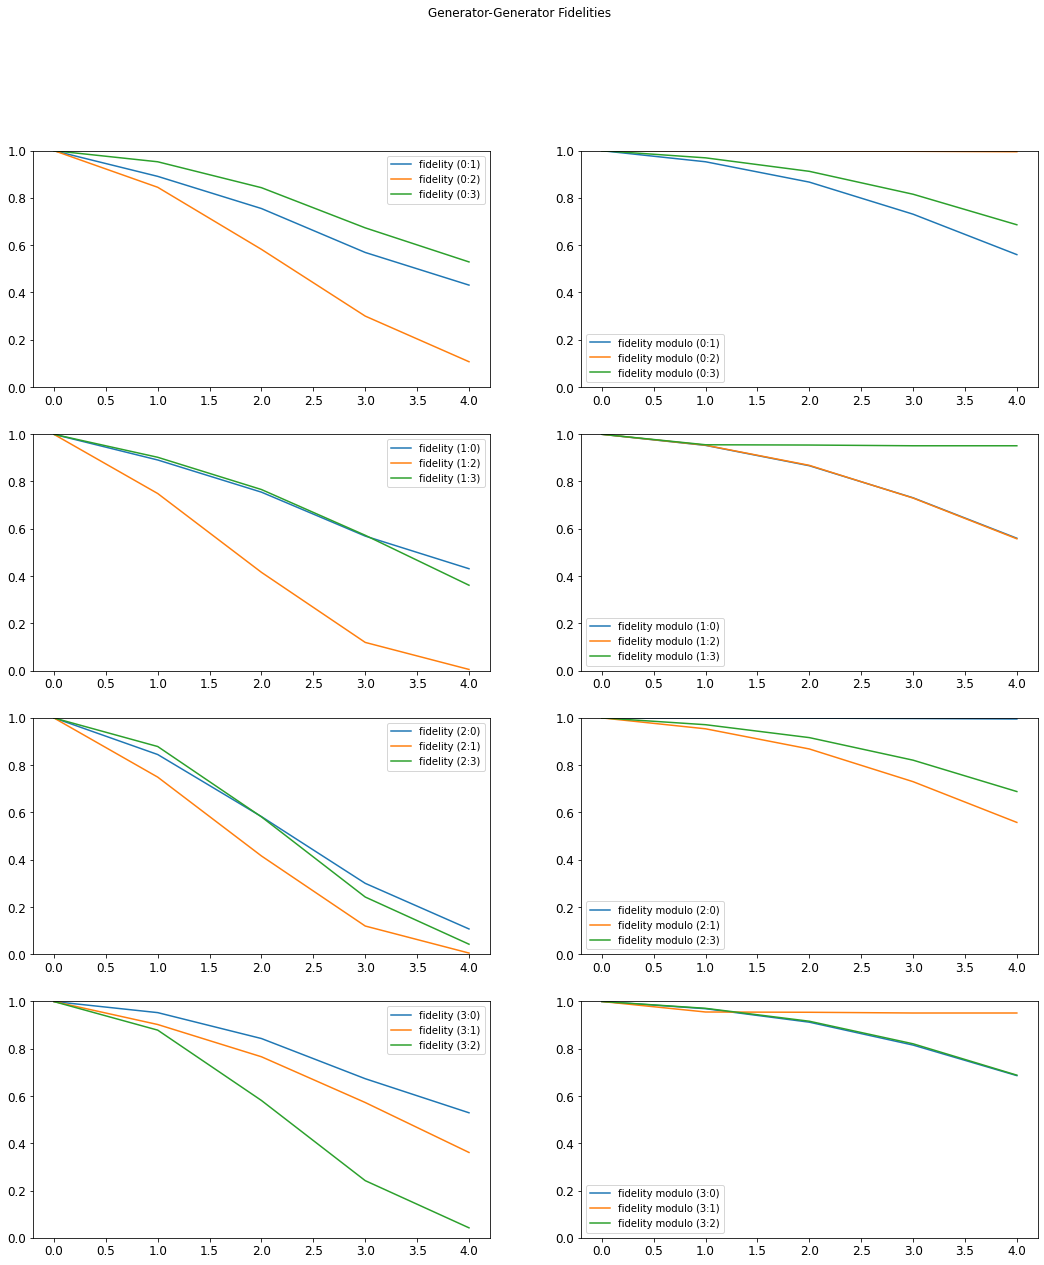

----------------------------------------------------
Epoch 4:  EM distance = 1.5349668985633664, trace distance = 0.9909651683800904, abs trace distance = 0.8868462703993343
h=Z((0, 2)), w=0.4999999992288345, e=0.590225100517273
h=Z((0, 2)), w=0.4999999991542018, e=0.590225100517273
h=X((0, 3))*Z((0, 4)), w=0.49999999962953173, e=0.37895217537879944
h=X((0, 0))*X((0, 1)), w=0.9999999982965186, e=0.7552657127380371
-------------------------------------
----------- TRAINING DONE -----------


In [373]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [ ]:
def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    gene rated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real), cirq.fidelity(abs(generated), abs(real))

In [ ]:
def get_all_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    generated = gen_evaluator.get_all_states_from_params()
    real = real_evaluator.get_all_states_from_params()
    
    return generated, real, 

In [306]:
gen_evaluator = trainer.gen_evaluator
real_evaluator = trainer.real_evaluator

In [161]:
if use_neptune:
    neptune.log_artifact(io.StringIO(gen_evaluator.get_resolved_circuit().to_qasm()), 'gen_qasm.txt')
    neptune.log_artifact(io.StringIO(json_result), 'full_snapshot.json')

In [162]:
g = g_values[0]
generated_state, real_state, fidelity, abs_fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, g, data_bus_size)

AttributeError: 'tuple' object has no attribute 'shape'

In [163]:
generated_state, real_state, fidelity, abs_fidelity

(array([-0.05575167+0.01085896j, -0.25746155+0.22038072j,
         0.05723193+0.11424299j, -0.0473222 -0.15260999j,
        -0.00850839-0.01677223j,  0.06304847+0.26141012j,
        -0.213855  +0.06023974j,  0.13515702+0.01083883j,
         0.04055541-0.00227634j,  0.18247546-0.14448078j,
        -0.04050408-0.07218367j,  0.02858929+0.10464625j,
        -0.0041999 -0.01296956j,  0.09063134+0.19917275j,
        -0.16897845+0.07290393j,  0.11115175-0.01160962j,
        -0.04396055+0.04755507j, -0.08282007+0.3839464j ,
         0.13557842+0.06327717j, -0.15091646-0.10723078j,
        -0.0157453 -0.00821999j,  0.20566165+0.19572133j,
        -0.15350345+0.17146744j,  0.12605444-0.06729285j,
         0.03155028-0.01814444j,  0.07758994-0.17865914j,
        -0.0548393 -0.03313485j,  0.06187999+0.06549712j,
        -0.01034328-0.01363869j,  0.17155498+0.15814075j,
        -0.13960254+0.14601904j,  0.10464948-0.0580539j ], dtype=complex64),
 array([ 0.19520226+0.j,  0.21824276+0.j,  0.19520229

In [166]:
trainer.get_fidelty_for_real()

([FidelityGrid(prob_gen=0.16710262, label_gen=0, prob_real=0.5, label_real=-0.8, fidelity=0.1127651173624713, abs_fidelity=0.3421704423954033),
  FidelityGrid(prob_gen=0.83289737, label_gen=1, prob_real=0.5, label_real=-0.8, fidelity=0.1798365028961948, abs_fidelity=0.7074837646531797),
  FidelityGrid(prob_gen=0.16710262, label_gen=0, prob_real=0.5, label_real=-0.2, fidelity=0.06658932295886544, abs_fidelity=0.168936787739554),
  FidelityGrid(prob_gen=0.83289737, label_gen=1, prob_real=0.5, label_real=-0.2, fidelity=0.2993313970456626, abs_fidelity=0.7225261833655736)],
 [GeneratorsFidelityGrid(label_gen1=0, label_gen2=1, fidelity=0.00013485971835296932, abs_fidelity=0.11192112566152801),
  GeneratorsFidelityGrid(label_gen1=1, label_gen2=0, fidelity=0.00013485971835296932, abs_fidelity=0.11192112566152801)])

In [167]:
gen_evaluator.get_all_states_from_params()

[(0.16710262,
  0,
  array([ 0.01336192+3.9932518e-03j,  0.12021226+1.3864566e-01j,
          0.10978296-7.5897872e-03j, -0.17012224-7.2150218e-01j,
         -0.01213372+8.7265432e-02j,  0.16082495-2.0709528e-01j,
          0.04828   +4.5394685e-02j,  0.21565254-1.3421544e-01j,
          0.01651314+1.4358209e-03j, -0.00753847-1.6508125e-02j,
          0.01604618+1.1066440e-06j, -0.04793194-8.0139466e-02j,
          0.02196432+3.2793578e-02j, -0.00571851-1.4710495e-01j,
          0.03200601+1.8872766e-02j,  0.155507  -1.4135516e-01j,
          0.00424529+4.7643892e-03j,  0.0106416 +8.6790957e-02j,
          0.04543811+2.5648918e-02j,  0.12155427-3.2940531e-01j,
         -0.02867612+3.1398512e-02j,  0.12110662-3.8074996e-02j,
          0.00643949+3.1106293e-02j,  0.12176984+8.1751226e-03j,
          0.00351928+5.4166024e-03j,  0.00741182-6.8423795e-03j,
          0.00471731+3.0584685e-03j, -0.0002406 -3.8405363e-02j,
         -0.0073669 +1.4311011e-02j,  0.05034477-3.2068074e-02j,
      

In [168]:
real_evaluator.get_all_states_from_params()

[(0.5,
  -0.8,
  array([ 0.19520226+0.j,  0.21824276+0.j,  0.19520229+0.j, -0.17459425+0.j,
         -0.15616189+0.j, -0.17459427+0.j,  0.19520235+0.j, -0.17459428+0.j,
         -0.15616184+0.j, -0.17459424+0.j, -0.15616186+0.j,  0.13967541+0.j,
         -0.15616187+0.j, -0.17459425+0.j,  0.1952023 +0.j, -0.17459425+0.j,
          0.17459425+0.j,  0.1952023 +0.j,  0.17459428+0.j, -0.15616187+0.j,
         -0.13967544+0.j, -0.15616186+0.j,  0.17459428+0.j, -0.15616187+0.j,
         -0.17459428+0.j, -0.19520234+0.j, -0.1745943 +0.j,  0.15616187+0.j,
         -0.17459428+0.j, -0.19520234+0.j,  0.21824285+0.j, -0.19520232+0.j],
        dtype=complex64),
  array([0.19520226, 0.21824276, 0.19520229, 0.17459425, 0.15616189,
         0.17459427, 0.19520235, 0.17459428, 0.15616184, 0.17459424,
         0.15616186, 0.13967541, 0.15616187, 0.17459425, 0.1952023 ,
         0.17459425, 0.17459425, 0.1952023 , 0.17459428, 0.15616187,
         0.13967544, 0.15616186, 0.17459428, 0.15616187, 0.1745942

In [320]:
l, v = np.linalg.eig(
            (real_evaluator.get_density_matrix(True) - gen_evaluator.get_density_matrix(True)).numpy())

In [321]:
sum(abs(np.real(l))) / 2

0.060158500165295455

In [309]:
gen_evaluator.get_density_matrix(True)

<tf.Tensor: shape=(32, 32), dtype=complex64, numpy=
array([[0.03255424+0.j, 0.03690104+0.j, 0.03284064+0.j, ...,
        0.03301864+0.j, 0.03633329+0.j, 0.03244355+0.j],
       [0.03690104+0.j, 0.04182825+0.j, 0.03722568+0.j, ...,
        0.03742745+0.j, 0.04118469+0.j, 0.03677557+0.j],
       [0.03284064+0.j, 0.03722568+0.j, 0.03312955+0.j, ...,
        0.03330912+0.j, 0.03665294+0.j, 0.03272897+0.j],
       ...,
       [0.03301864+0.j, 0.03742745+0.j, 0.03330912+0.j, ...,
        0.03348967+0.j, 0.03685161+0.j, 0.03290638+0.j],
       [0.03633329+0.j, 0.04118469+0.j, 0.03665294+0.j, ...,
        0.03685161+0.j, 0.04055104+0.j, 0.03620976+0.j],
       [0.03244355+0.j, 0.03677557+0.j, 0.03272897+0.j, ...,
        0.03290638+0.j, 0.03620976+0.j, 0.03233324+0.j]], dtype=complex64)>

In [308]:
real_evaluator.get_density_matrix(True)

<tf.Tensor: shape=(32, 32), dtype=complex64, numpy=
array([[0.03810392+0.j, 0.04260148+0.j, 0.03810393+0.j, ...,
        0.03810394+0.j, 0.0426015 +0.j, 0.03810393+0.j],
       [0.04260148+0.j, 0.0476299 +0.j, 0.04260149+0.j, ...,
        0.0426015 +0.j, 0.04762992+0.j, 0.0426015 +0.j],
       [0.03810393+0.j, 0.04260149+0.j, 0.03810393+0.j, ...,
        0.03810394+0.j, 0.0426015 +0.j, 0.03810394+0.j],
       ...,
       [0.03810394+0.j, 0.0426015 +0.j, 0.03810394+0.j, ...,
        0.03810395+0.j, 0.04260151+0.j, 0.03810395+0.j],
       [0.0426015 +0.j, 0.04762992+0.j, 0.0426015 +0.j, ...,
        0.04260151+0.j, 0.04762994+0.j, 0.04260151+0.j],
       [0.03810393+0.j, 0.0426015 +0.j, 0.03810394+0.j, ...,
        0.03810395+0.j, 0.04260151+0.j, 0.03810395+0.j]], dtype=complex64)>

In [343]:
json_result

'[\n  {\n    "abs_trace_distance": 0.9669262768592459,\n    "trace_distance": 0.9975481968050319,\n    "gen_pairs": [\n      [\n        "0.25",\n        0,\n        {\n          "theta0": -0.02846965752542019,\n          "theta1": -0.027243375778198242,\n          "theta2": 0.017021307721734047,\n          "theta3": 0.01072680577635765,\n          "theta4": 0.007494843099266291,\n          "theta5": -0.008468382991850376,\n          "theta6": -0.027422601357102394,\n          "theta7": -0.007387822028249502,\n          "theta8": -0.001877862960100174,\n          "theta9": -0.016427796334028244,\n          "theta10": 0.0017173918895423412,\n          "theta11": 0.005322509445250034,\n          "theta12": 0.01198945939540863\n        }\n      ],\n      [\n        "0.25",\n        1,\n        {\n          "theta0": 0.005611424800008535,\n          "theta1": -0.00682742428034544,\n          "theta2": 0.012090443633496761,\n          "theta3": 0.004276816733181477,\n          "theta4": 0.01